# Deep Learning Course - Exercise 1

* Alon Mizrahi 312284706
* Nimrod Curtis 311230924

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

### Import

In [ ]:
## To import google drive, write this code in code section of colab and run it
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import sys

# torch
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import init
import torchvision

### Globals

In [ ]:
# hyperparameters: (default)
batch_size = 100
epochs = 60
lr = 1e-4

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else 'cpu') #You can train all networks on Cuda except batch normalization.
device = torch.device('cpu')
print(f'Device: {device}')

Device: cpu


### Utils

In [ ]:
def plot_accuracy(train_acc, test_acc, name):

    epochs_idx = range(1, len(train_acc) + 1)
    # Plot the train and test accuracy 
    plt.plot(epochs_idx, train_acc, color='black', label='Training accuracy')
    plt.plot(epochs_idx, test_acc, color='red', label='Testing accuracy')
    
    
    plt.xticks(range(0, len(train_acc) + 1, 5))
    plt.title(f'Accuracy convergence graph - {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy [%]')
    plt.legend()
    
    # Show the plot
    plt.show()


In [ ]:
def check_model_acc(model, tr_loader, te_loader):
    tr_acc = 0
    count = 0
    for X_batch, y_batch in tr_loader:
        X_batch=X_batch.to(device)
        y_batch=y_batch.to(device)
        y_pred = model(X_batch)
        tr_acc += (torch.argmax(y_pred, 1) == y_batch).float().sum()
        count += len(y_batch)
    tr_acc = 100*tr_acc / count

    te_acc = 0
    count = 0
    for X_batch, y_batch in te_loader:
        X_batch=X_batch.to(device)
        y_batch=y_batch.to(device)
        y_pred = model(X_batch)
        te_acc += (torch.argmax(y_pred, 1) == y_batch).float().sum()
        count += len(y_batch)
    te_acc = 100*te_acc / count

    print("model final accuracy train: %.2f%% | test: %.2f%%" % (tr_acc, te_acc))


In [ ]:
def show_batch(images, labels, predictions,step,cols=10):
    # Get batch size
    batch_size = len(images)
    rows = int(batch_size // cols)

    
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 30))
    fig.suptitle(f"Actual vs Predicted | Batch: {step}", fontsize=10)

    # Move images tensor from GPU to CPU and convert to numpy array
    images = images.detach().numpy()
    labels = labels.detach().numpy()
    
    predicted = torch.argmax(predictions, 1)
    predicted = predicted.detach().numpy()
    

    # Create grid of images
    images = np.transpose(images, (0, 2, 3, 1))
        
    # Loop through each image and label, and display actual vs predicted label in title
    for i in range(batch_size):
        image = images[i].astype(np.uint8)
        actual_label = labels[i]
        predicted_label = predicted[i]
        correct = (predicted_label == actual_label)
        # Set title color based on correct/wrong prediction
        if correct:
            color = 'green'
        else:
            color = 'red'
        
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()    
        ax.ravel()[i].set_title("Label: {} Pred: {}".format(actual_label, predicted_label), color=color, fontsize=8,loc='center')

    plt.tight_layout()
    plt.show()

### Model - Lenet5

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, Dropout = None, BatchNormalize = None):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.act1 = nn.Tanh()
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.act2 = nn.Tanh()
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.act3 = nn.Tanh()
        self.bn3 = nn.BatchNorm2d(num_features=120)

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(1*1*120, 84)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(84, 10)
        
        self.dropout = Dropout
        self.batchnormalize = BatchNormalize
        self.drop = nn.Dropout(0.25)
                
        
        

    def forward(self, x):
        # input 1x28x28, output 6x28x28
        x = self.act1(self.conv1(x))
        if self.dropout is not None:
          x = self.drop(x)
        if self.batchnormalize is not None:
          x = self.bn1(x)
        # input 6x28x28, output 6x14x14
        x = self.pool1(x)
        # input 6x14x14, output 16x10x10
        x = self.act2(self.conv2(x))
        if self.dropout is not None:
          x = self.drop(x)
        if self.batchnormalize is not None:
          x = self.bn2(x)
        # input 16x10x10, output 16x5x5
        x = self.pool2(x)
        # input 16x5x5, output 120x1x1
        x = self.act3(self.conv3(x))
        if self.dropout is not None:
          x = self.drop(x)
        if self.batchnormalize is not None:
          x = self.bn3(x)
        # input 120x1x1, output 84
        x = self.act4(self.fc1(self.flat(x)))
        # input 84, output 10
        x = self.fc2(x)
        return x

### Data

In [ ]:
def load_mnist_dataset(batch_size = 100):

  transform = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean=0.3814, std=0.3994),
  ])

  root_dir = "../../OOP" 
  train = torchvision.datasets.FashionMNIST(root=root_dir, train=True,
                                                transform=transform, 
                                                download=True )

  test = torchvision.datasets.FashionMNIST(root=root_dir, train=False,
                                               transform=transform, 
                                               download=True )
  trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=batch_size)
  testloader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=batch_size)
  
  return trainloader, testloader

### Train

In [ ]:
def train(model, trainloader, testloader, lr=1e-3, n_epochs=20, weight_decay=None):  
  if weight_decay is not None:
    optimizer = optim.Adam(model.parameters(), lr=lr ,weight_decay=weight_decay)
  else: optimizer = optim.Adam(model.parameters(), lr=lr)
  
  loss_fn = nn.CrossEntropyLoss()
  train_acc = []
  test_acc = []
  for epoch in range(n_epochs):
      
      model.train()
      for X_batch, y_batch in trainloader:

          X_batch=X_batch.to(device)
          y_batch=y_batch.to(device)
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      # Validation
      model.eval()
      tr_acc = 0
      count = 0
      for X_batch, y_batch in trainloader:
          X_batch=X_batch.to(device)
          y_batch=y_batch.to(device)
          y_pred = model(X_batch)
          tr_acc += (torch.argmax(y_pred, 1) == y_batch).float().sum()
          count += len(y_batch)
      tr_acc = 100*tr_acc / count
      train_acc.append(tr_acc.cpu().detach().numpy())

      te_acc = 0
      count = 0
      for X_batch, y_batch in testloader:
          X_batch=X_batch.to(device)
          y_batch=y_batch.to(device)
          y_pred = model(X_batch)
          te_acc += (torch.argmax(y_pred, 1) == y_batch).float().sum()
          count += len(y_batch)
      te_acc = 100*te_acc / count
      test_acc.append(te_acc.cpu().detach().numpy())
      
      # if ((epoch+1)%15 == 0):
      print("Epoch %d: model accuracy train: %.2f%% | test: %.2f%%" % (epoch+1, tr_acc, te_acc))

  return model, train_acc, test_acc

### Main Function

In [ ]:
def main(batch_size = 100, epochs = 60, lr = 1e-4, wd = None, do = None, bn = None, name='',PATH='/content/',save=False):
  
  tr_loader, te_loader = load_mnist_dataset(batch_size)
  model = LeNet5(do, bn)
  model = model.to(device)
  model, train_acc, test_acc = train(model, tr_loader, te_loader, lr, epochs, wd)

  plot_accuracy(train_acc, test_acc, name)
  print("model accuracy train: %.2f%% | test: %.2f%%" % (train_acc[-1], test_acc[-1]))

  #save trained model
  if save:
    torch.save(model.state_dict(), PATH+name+'new')

--------------------------------------------------------------------------
--------------------------------------------------------------------------

--------------------------------------------------------------------------
--------------------------------------------------------------------------


### For the Instructor
1. First set your relevant paths:
  - models dir
  - plots dir (optional if you would like to see convergence graphs we saved)

2. The choose to train/load model :
  - Load Trained Model and Test it (flag = 1)
  - Train new model (flag = 0)

3. Finally pick the regularization method from:

  - 'Batch_Normalization' 
  - 'Dropout' 
  - 'Weight_Decay' 
  - 'Without_Regularization'

Then run the cell after, good luck! 

In [ ]:
# 1. 
# path to model dir
# TODO
PATH= '/content/gdrive/MyDrive/Deep Learning Course/Exercises/EX_1_DL_basics/312284706_311230924_ex/models/'

# path to plots dir (optional)
PATH_to_our_images = '/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning_Course/Exercises/EX_1_DL_basics/312284706_311230924_ex/plots/new_lr_1e-4/'

# 2. 
# Train new model  -> flag = 0
# Load model -> flag = 1
flag = 1 

# 3.
name = 'Batch_Normalization' #'Without_Regularization'# 'Dropout' #'Batch_Normalization' #'Dropout' #'Weight_Decay'

## Init regularization params
if name == 'Weight_Decay': wd = 1e-3 
else: wd = None

if name == 'Dropout': do = 1
else: do = None

if name == 'Batch_Normalization':bn = 1 
else: bn = None

if name == 'Without_Regularization': bn,do,wd = None,None,None
else: pass 



Test saved model of Batch_Normalization...
model final accuracy train: 95.16% | test: 90.16%


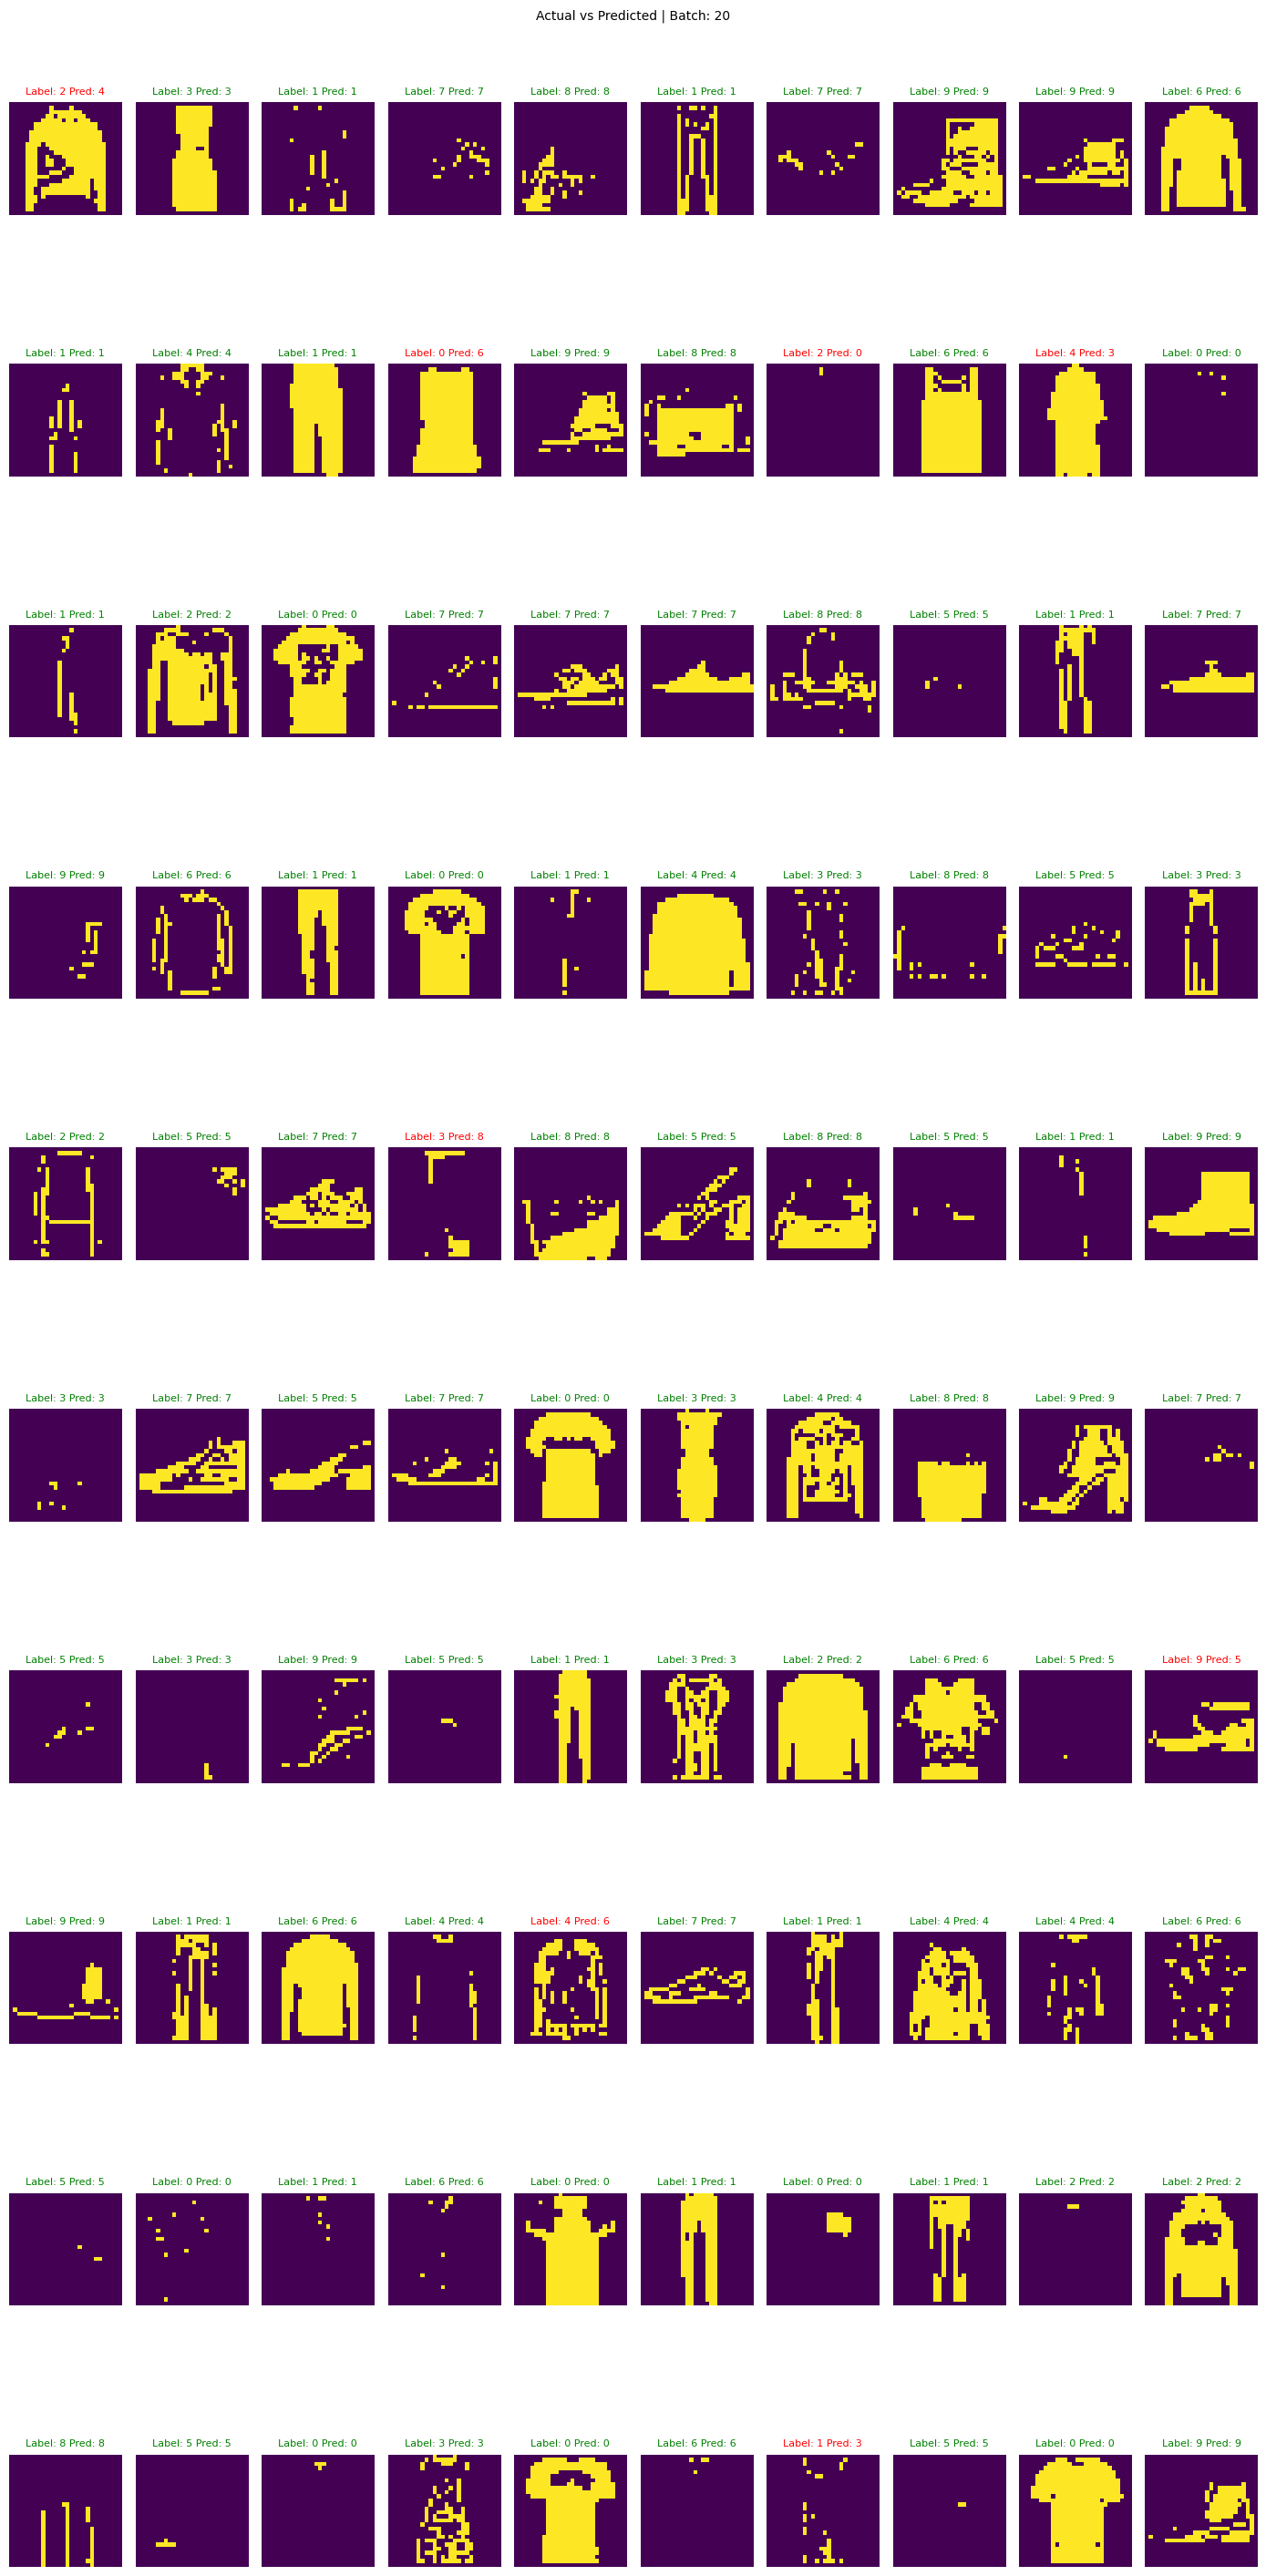

In [ ]:
if flag == 0:
  print(f"Start training of {name}...")
  main(batch_size, epochs, lr,wd, do, bn, name ,PATH,save=True)

elif flag == 1:
  # load data
  tr_loader, te_loader = load_mnist_dataset(batch_size)
  # init and load model 
  model = LeNet5(BatchNormalize=bn)
  model.load_state_dict(torch.load(PATH+name, map_location=device))
  model.eval()
  print(f"Test saved model of {name}...")
  # test model
  check_model_acc(model, tr_loader, te_loader)

  ### Visualize outputs ###
  # Plot a batch inference , pick a specific batch from the test DataLoader
  batch_idx = 20
  for i, batch in enumerate(te_loader):
      if i == batch_idx:
          images, targets = batch
          break
  preds = model(images)
  show_batch(images=images, labels=targets,predictions=preds,step=batch_idx)


### Our Runs

We executed he main function 4 times, 1 training for each regularization method.

You can see the cells below with the commented code. 

Then you can show the plots we got after training the 4 models.

In [ ]:
# print('------------------------------------------------------------------------------------')
# print('---------------------------- Without Regularization --------------------------------')
# print('------------------------------------------------------------------------------------')
# main(batch_size, epochs, lr,None, None, None, 'Without_Regularization',PATH)

In [ ]:
# print('------------------------------------------------------------------------------------')
# print('---------------------------------- Weight Decay ------------------------------------')
# print('------------------------------------------------------------------------------------')
# main(batch_size, epochs, lr,1e-3, None, None, 'Weight_Decay',PATH)

In [ ]:
# print('------------------------------------------------------------------------------------')
# print('------------------------------------ Dropout ---------------------------------------')
# print('------------------------------------------------------------------------------------')
# main(batch_size, epochs, lr,None, 1, None, 'Dropout',PATH)

In [ ]:
# print('------------------------------------------------------------------------------------')
# print('------------------------------- Batch Normalization --------------------------------')
# print('------------------------------------------------------------------------------------')
# main(batch_size, epochs, lr,None, None, 1, 'Batch_Normalization',PATH)

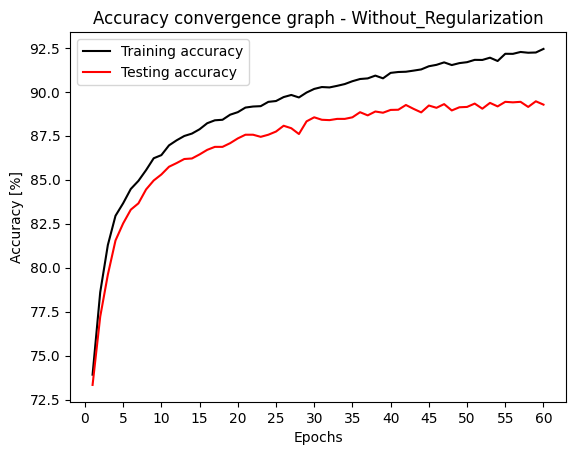

In [ ]:
from IPython.display import Image

Image(filename = PATH_to_our_images+'without_reg.png')

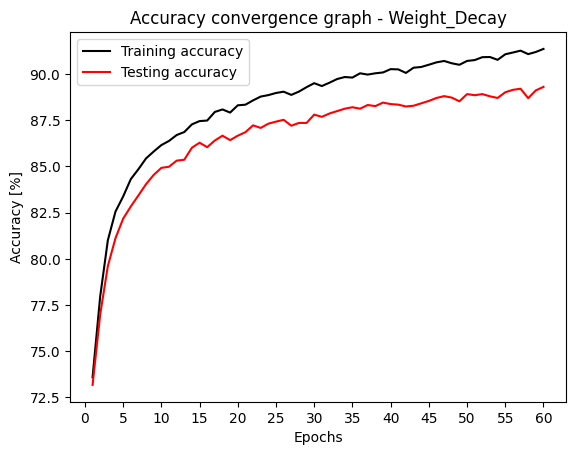

In [ ]:
Image(filename = PATH_to_our_images+'weight_decay.png')

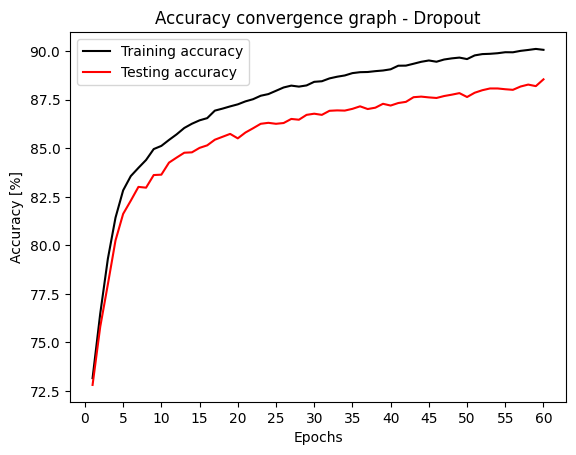

In [ ]:
Image(filename = PATH_to_our_images+'dropout.png')

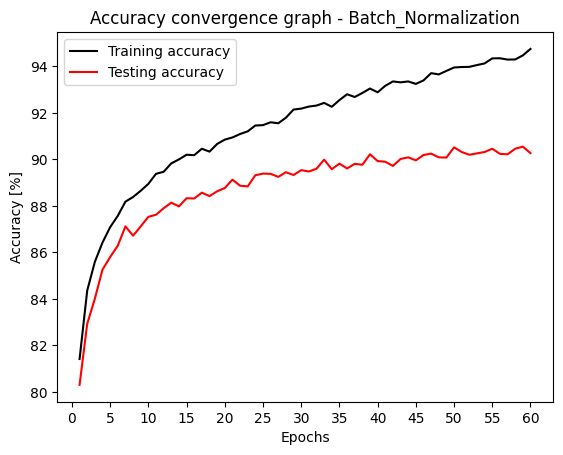

In [ ]:
Image(filename = PATH_to_our_images+'batch_normalization.png')